Código del repo de la materia siu

La mejor opción es leer la descripción en el repo de la materia, si lo intento pegar, se termina viendo horrible.

In [129]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Con ''SimultaneousActivation, hacemos que todos los agentes se activen ''al azar''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(metric="euclidean")

In [130]:
class FlockAgent(Agent):
    def __init__(self, id, model, x, y, width, height):
        super().__init__(id, model)
        
        # Esto nos da una posición aleatoria en el espacio para el agente
        self.position = np.array((x, y), dtype = np.float64)
        
        # Esto nos da una velocidad aleatoria en el espacio para el agente
        vec = (np.random.rand(2) - 0.5) * 10
        self.velocity = np.array(vec, dtype = np.float64)
        
        # Esto nos da una aceleración aleatoria en el espacio para el agente
        vec = (np.random.rand(2) - 0.5) / 2
        self.acceleration = np.array(vec, dtype = np.float64)
        
        self.max_force = 0.3
        self.max_speed = 5
        self.width = width
        self.height = height   
        self.perception = 50
        
    # Esta definición hace que el agente se mueva
    def step(self):
        self.check_edges()
        self.check_with_neighbors()
    
        self.position = self.position + self.velocity
        self.velocity = self.velocity + self.acceleration
        
        if np.linalg.norm(self.velocity) > self.max_speed:
            self.velocity = self.velocity / (np.linalg.norm(self.velocity) * self.max_speed)
                
        #El np.float64 es para que no se convierta en un float32, esto es para que no haya problemas de precisión.
        self.acceleration = np.array((0, 0), dtype = np.float64)
                
    # Esta definicion hace que sea toroidal, es decir, que si se sale por un lado, aparece por el otro.
    def check_edges(self):
        if self.position.flatten()[0] > self.width:
            self.position[0] = 0
        elif self.position.flatten()[0] < 0:
            self.position[0] = self.width
            
        if self.position.flatten()[1] > self.height:
            self.position[1] = 0
        elif self.position.flatten()[1] < 0:
            self.position[1] = self.height    
            
    # Esta definición revisa los vecinos del agente
    def check_with_neighbors(self):
        alignment = self.align()
        cohesion = self.cohesion()
        separation = self.separation()
        
        self.acceleration += alignment
        self.acceleration += cohesion   
        self.acceleration += separation 
        
    #esta definición alinea al agente con sus vecinos
    def align(self):
        steering = np.array((0,0), dtype = np.float64)
        avg_vector = np.array((0,0), dtype = np.float64)
        
        result = neighbors.radius_neighbors([self.position],
                                            self.perception)[1][0]
        
        #Esto nos da el promedio de las velocidades de los agentes
        for idx in result:
            avg_vector += self.model.schedule.agents[idx].velocity
            
            
        total = len(result)
        if total > 0:
            avg_vector /= total
            #Ajustamos el vector para que esté dentro de los limites de velocidad. Una vez ajustado, se define el giro (steering) que va a tener
            avg_vector /= (avg_vector / np.linalg.norm(avg_vector)) * self.max_speed
            steering = avg_vector - self.velocity
            
        return steering

    #Esta deficinición nos da la cohesión de los agentes, es decir, que se acerquen a los demás
    def cohesion(self):
        steering = np.array((0,0), dtype = np.float64) 
        center_of_mass = np.array((0,0), dtype = np.float64)   
        
        result = neighbors.radius_neighbors([self.position],
                                            self.perception)[1][0]
        
        for idx in result:
            center_of_mass += self.model.schedule.agents[idx].position
            
        total = len(result)
        if total > 0:
            center_of_mass /= total
            vec_to_com = center_of_mass - self.position
            if np.linalg.norm(vec_to_com) > 0:
                vec_to_com = (vec_to_com / np.linalg.norm(vec_to_com)) * self.max_speed
            steering = vec_to_com - self.velocity
            if np.linalg.norm(steering) > 0:
                steering = (steering / np.linalg.norm(steering)) * self.max_force
                
        return steering
    
    #Esta definición nos da la separación de los agentes, es decir, que no se choquen
    def separation(self):
        steering = np.array((0, 0), dtype = np.float64)
        avg_vector = np.array((0, 0), dtype = np.float64)
        
        result = neighbors.radius_neighbors([self.position],
                                            self.perception)[1][0]
        
        for idx in result: 
            if not(np.array_equal(self.position,
                                self.model.schedule.agents[idx].position)):
                diff = self.position - self.model.schedule.agents[idx].position
                avg_vector += diff
                
        total = len(result)
        if total > 0:
            avg_vector /= total
            if np.linalg.norm(avg_vector) > 0:
                avg_vector = (avg_vector / np.linalg.norm(avg_vector)) * self.max_speed
                
            steering = avg_vector - self.velocity
            if np.linalg.norm(steering) > 0:
                steering = (steering / np.linalg.norm(steering)) * self.max_force
        
        return steering

In [131]:
# Esta definición obtiene las posiciones del modelo
def get_particles(model):
    result = []
    for agent in model.schedule.agents:
        result.append(agent.position)
    result = np.asarray(result)
    return result

In [132]:
# El modelo de Flocking se basa en el modelo de Boids de Craig Reynolds
class FlockModel(Model):
    def __init__(self,num_agents, width, height):
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            model_reporters = {"Particles": get_particles})
        
        data = None
        for i in range (num_agents):
            x = np.random.rand() * width
            y = np.random.rand() * height
            agent = FlockAgent(i, self, x, y, width, height)
            self.schedule.add(agent)
            
            if data is None:
                data = np.array([[x,y]])
            else:
                data = np.concatenate( (data, [[x, y]]) )
        
        neighbors.fit(data)
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [133]:
WIDTH = 1000
HEIGHT = 1000
AGENTS = 200
MAX_ITERATIONS = 2000

model = FlockModel(AGENTS, WIDTH, HEIGHT)
for i in range(MAX_ITERATIONS):
    model.step()

/var/folders/dw/nsj8k1jn21760l17xw4r_f4w0000gn/T/ipykernel_10244/3725319304.py:75: RuntimeWarning: invalid value encountered in divide
  avg_vector /= (avg_vector / np.linalg.norm(avg_vector)) * self.max_speed
/var/folders/dw/nsj8k1jn21760l17xw4r_f4w0000gn/T/ipykernel_10244/3725319304.py:75: RuntimeWarning: invalid value encountered in divide
  avg_vector /= (avg_vector / np.linalg.norm(avg_vector)) * self.max_speed
/var/folders/dw/nsj8k1jn21760l17xw4r_f4w0000gn/T/ipykernel_10244/3725319304.py:75: RuntimeWarning: invalid value encountered in divide
  avg_vector /= (avg_vector / np.linalg.norm(avg_vector)) * self.max_speed
/var/folders/dw/nsj8k1jn21760l17xw4r_f4w0000gn/T/ipykernel_10244/3725319304.py:75: RuntimeWarning: invalid value encountered in divide
  avg_vector /= (avg_vector / np.linalg.norm(avg_vector)) * self.max_speed


ValueError: Input X contains NaN.
NearestNeighbors does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
all_positions = model.datacollector.get_model_vars_dataframe()
all_positions.head(5)

,Positions
0,"[None, None, None, None, None, None, None, Non..."
1,"[None, None, None, None, None, None, None, Non..."
2,"[None, None, None, None, None, None, None, Non..."
3,"[None, None, None, None, None, None, None, Non..."
4,"[None, None, None, None, None, None, None, Non..."


TypeError: list indices must be integers or slices, not tuple

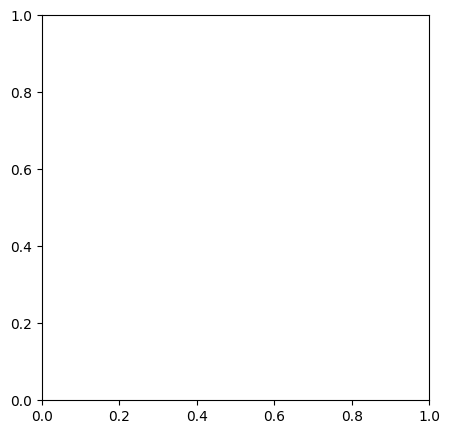

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
scatter = ax.scatter(all_positions.iloc[0][0][:, 0], all_positions.iloc[0][0][:, 1], s=10, edegcolor="k")
ax.axis([0, WIDTH, o, HEIGHT])

def animate(i):
    scatter.set_offsets(all_positions.iloc[i][0])

anim = animation.FuncAnimation(fig, animate, frames=100, interval=100)

anim